In [1]:
import sys
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime, timedelta
from random import randrange
import numpy as np
import math
from tqdm import tqdm
import csv
import random

In [2]:
# Задаём число аккаунтов в сети и общее число токенов

n = 1000 
G = nx.complete_graph(n)
token_supply = 100000000
token_distribution = {'exchange':0.6}


In [3]:
# Распределяем роли в сети и их количество

ro = [0.001, 0.36, 0.34, 0.2, 0]

roles = {'exchange':int(ro[0]*n), 
         'buyer':int(ro[1]*n), 
         'seller':int(ro[2]*n), 
         'hodler':int(ro[3]*n), 
         'speculator':int(n-(sum(ro[0:4]))*n)}

for node in G.nodes()[0:roles['exchange']]:
    G.node[node]['account_type'] = 'exchange'
for node in G.nodes()[roles['exchange']:roles['exchange']+roles['buyer']]:
    G.node[node]['account_type'] = 'buyer'
for node in G.nodes()[roles['exchange']+roles['buyer']:
                      roles['exchange']+roles['buyer']+roles['seller']]:
    G.node[node]['account_type'] = 'seller'
for node in G.nodes()[roles['exchange']+roles['buyer']+roles['seller']:
                      roles['exchange']+roles['buyer']+roles['seller']+roles['hodler']]:
    G.node[node]['account_type'] = 'hodler'
for node in G.nodes()[roles['exchange']+roles['buyer']+roles['seller']+roles['hodler']:n]:
    G.node[node]['account_type'] = 'speculator'


In [4]:
# Задаём макс. баланс токенов, доступный каждому из участников, его покупательную способность

def set_max_balances(G, token_supply):
    #normal = token_supply*(0.03*np.random.randn(1,n) + 0.1).tolist()[0]
    beta = np.random.beta(2, 9, n).tolist()
    dist = beta
    for node in G.nodes():
        if G.node[node]['account_type'] == 'exchange':
            G.node[node]['max_balance'] = 0.8*token_supply
        else:
            if dist[node] > 0:
                G.node[node]['max_balance'] = token_supply*dist[node]
            else:
                G.node[node]['max_balance'] = 1
    return (token_supply*min(dist), token_supply*max(dist))

# Задаём стартовую пустую историю транзакций между каждой парой пользователей

def set_initial_history(graph):
    for edge in G.edges():
        if edge[0] < edge[1]:
            G.edge[edge[0]][edge[1]]['tx_history'] = []
        

        
# Транзакция на ребре подразумевает, что первый аккаунт - отправитель, второй - получатель

def transaction(graph, edge, amount, timestamp):
    
    #Проверяем упорядоченность ребра
    if edge[0] < edge[1]:
    
        #Проверяем, есть ли такая пара пользователей в сети
        if edge in graph.edges():

            '''
            Проверяем, достаточно ли у отправителя средств
            Проверяем, что получатель имеет достаточную покупательную способность
            Записываем транзакцию в историю
            Вычитаем пункт из числа отправлений, доступных аккаунту
            '''

            if (graph.node[edge[0]]['balance'] >= amount) and\
            (graph.node[edge[1]]['balance'] + amount <= graph.node[edge[1]]['max_balance']) and\
            (graph.node[edge[0]]['send'] >= 1):
                graph.node[edge[0]]['balance'] -= amount
                graph.node[edge[1]]['balance'] += amount
                graph.node[edge[0]]['send'] -= 1
                graph.node[edge[1]]['receive'] += 1
                graph.edge[edge[0]][edge[1]]['tx_history'].append({'timestamp':timestamp,
                                                      'from and to':edge,
                                                      'amount':amount})

            else:
                pass
        
    #Сам себе в системе аккаунт не может отправлять деньги
    elif edge[0] == edge[1]:
        pass
        
    else:
        edge_reverse = edge[::-1]
            
        #Проверяем, есть ли такая пара пользователей в сети
        if edge_reverse in graph.edges():

            '''
            Проверяем, достаточно ли у отправителя средств
            Проверяем, что получатель имеет достаточную покупательную способность
            Записываем транзакцию в историю
            '''

            if (graph.node[edge_reverse[0]]['balance'] >= amount) and\
            (graph.node[edge_reverse[1]]['balance'] + amount <= graph.node[edge_reverse[1]]['max_balance']):
                graph.node[edge_reverse[0]]['balance'] -= amount
                graph.node[edge_reverse[1]]['balance'] += amount
                graph.node[edge_reverse[0]]['send'] -= 1
                graph.node[edge_reverse[1]]['receive'] += 1
                graph.edge[edge_reverse[0]][edge_reverse[1]]['tx_history'].append({'timestamp':timestamp,
                                                          'from and to':edge,
                                                          'amount':amount})

            else:
                pass
    
    #print(graph.node[edge[0]])
    #print(graph.node[edge[1]])
    #print(graph.edge[edge[0]][edge[1]]['tx_history'])
    if graph.edge[edge[0]][edge[1]]['tx_history'] != []:
        
        #return [graph.edge[edge[0]][edge[1]]['tx_history'][-1]['timestamp'],
                #graph.edge[edge[0]][edge[1]]['tx_history'][-1]['from and to'],
                #graph.edge[edge[0]][edge[1]]['tx_history'][-1]['amount'],
                #graph.node[edge[0]]['account_type'],
                #'to',
                #graph.node[edge[1]]['account_type'],
                #datetime.fromtimestamp(graph.edge[edge[0]][edge[1]]['tx_history'][-1]['timestamp'])\
                #.strftime('%Y-%m-%d %H:%M:%S')]
        
        return [datetime.fromtimestamp(graph.edge[edge[0]][edge[1]]['tx_history'][-1]['timestamp']).\
                strftime('%Y-%m-%dT%H:%M:%S'), edge[0], edge[1],\
                graph.edge[edge[0]][edge[1]]['tx_history'][-1]['amount'], 20]
    else:
        return []

In [5]:
'''
Первый вариант - генерируем времена транзакций с произвольными промежутками времени, i - количество транзакций
'''

def random_date(start,i):
    current = start
    while i >= 0:
        current = current + timedelta(minutes=randrange(10))
        yield current
        i-=1

'''
Второй вариант задания таймстампов - это уплотнение активности. Мы рассмотрим равномерную торговлю, экспоненциально
растущую торговлю, а также уплотнение торговли где-то посередине, задавая различные веса временным промежуткам
'''

#Делим интервал на желаемое число частей
def interval_divide(startDate, endDate, intervals):
    min = int(datetime.strptime(startDate, '%Y-%m-%d %H:%M:%S').strftime("%s"))
    max = int(datetime.strptime(endDate, '%Y-%m-%d %H:%M:%S').strftime("%s"))
    interval_size = round((max - min) / intervals)
    intervals_list = []
    start = min
    for start in range(min, max, interval_size):
        end = start + interval_size
        intervals_list.append([start, end])
    print(intervals_list)
    return intervals_list

#Каждому интервалу с заданными вручную весами ставим в соответствие рандомную точку из этого интервала
def generate_weighted_activity(intervals, weights):
    weights = [w/sum(weights) for w in weights]
    tx_weighted_ts = []
    assert len(intervals) == len(weights)
    weighted_intervals = list(random.choices(intervals, weights, k=10000))
    for interval in weighted_intervals:
        tx_weighted_ts.append(random.uniform(interval[0], interval[1]))
    return tx_weighted_ts


In [6]:
#Проверяю число участников

exchanges = 0
buyers = 0
sellers = 0
hodlers = 0
speculators = 0

for node in G.nodes():
    if G.node[node]['account_type'] == 'exchange':
        exchanges += 1
    if G.node[node]['account_type'] == 'buyer':
        buyers += 1
    if G.node[node]['account_type'] == 'seller':
        sellers += 1
    if G.node[node]['account_type'] == 'hodler':
        hodlers += 1
    if G.node[node]['account_type'] == 'speculator':
        speculators += 1
        
'''
Здесь задаются параметры % от общей активности сети, приходящейся на ту или иную группу аккаунтов, 
и максимальное кол-во отправлений, доступных разным типам аакаунтов
'''

def set_max_activity(graph, tx_number, send):
    for node in graph.nodes():
        if graph.node[node]['account_type'] == 'exchange':
            graph.node[node]['send'] = send['exchange']*tx_number
            graph.node[node]['receive'] = 0
            
        if graph.node[node]['account_type'] == 'buyer':
            graph.node[node]['send'] = send['buyer']*tx_number
            graph.node[node]['receive'] = 0
            
        if graph.node[node]['account_type'] == 'seller':
            graph.node[node]['send'] = send['seller']*tx_number
            graph.node[node]['receive'] = 0
            
        if graph.node[node]['account_type'] == 'hodler':
            graph.node[node]['send'] = send['hodler']*tx_number
            graph.node[node]['receive'] = 0
            
        if graph.node[node]['account_type'] == 'speculator':
            graph.node[node]['send'] = send['speculator']*tx_number
            graph.node[node]['receive'] = 0



'''
Задаём стартовые балансы в сети, token_supply (type int)  - общее число токенов, token_distribution (type dictionary) - 
изначальное распределение токенов между биржей и пользователями, например 80% у биржи
'''

def set_start_balances(graph, token_supply, token_distribution):
    
    hodler_count = 0
    buyer_count = 0
    seller_count = 0
    speculator_count = 0
    beta = np.random.beta(2, 9, n).tolist()
    
    for node in G.nodes():
        
        if G.node[node]['account_type'] == 'exchange':
            
            # У биржи 60% средств изначально
            G.node[node]['balance']  = token_distribution['exchange']*token_supply
        
        elif G.node[node]['account_type'] != 'exchange' and (1-token_distribution['exchange'])\
            *token_supply*beta[node]<=G.node[node]['max_balance']:
            
            G.node[node]['balance'] = (1-token_distribution['exchange'])*\
            token_supply*beta[node]
        
        else:
            
            G.node[node]['balance'] = G.node[node]['max_balance']
            #print(node, 'max_balance')
    
    #Нормируем число токенов на общую сумму
    token_sum = 0
    exchange_token_sum = 0
    for node in G.nodes():
        if G.node[node]['account_type'] != 'exchange':
            token_sum += G.node[node]['balance']
        else:
            exchange_token_sum += G.node[node]['balance']
    
    for node in G.nodes():
        if G.node[node]['account_type'] != 'exchange':
            G.node[node]['balance'] = G.node[node]['balance']/(token_sum/(token_supply-exchange_token_sum))


[[1523955600, 1523961648], [1523961648, 1523967696], [1523967696, 1523973744], [1523973744, 1523979792], [1523979792, 1523985840], [1523985840, 1523991888], [1523991888, 1523997936], [1523997936, 1524003984], [1524003984, 1524010032], [1524010032, 1524016080], [1524016080, 1524022128], [1524022128, 1524028176], [1524028176, 1524034224], [1524034224, 1524040272], [1524040272, 1524046320], [1524046320, 1524052368], [1524052368, 1524058416], [1524058416, 1524064464], [1524064464, 1524070512], [1524070512, 1524076560], [1524076560, 1524082608], [1524082608, 1524088656], [1524088656, 1524094704], [1524094704, 1524100752], [1524100752, 1524106800], [1524106800, 1524112848], [1524112848, 1524118896], [1524118896, 1524124944], [1524124944, 1524130992], [1524130992, 1524137040], [1524137040, 1524143088], [1524143088, 1524149136], [1524149136, 1524155184], [1524155184, 1524161232], [1524161232, 1524167280], [1524167280, 1524173328], [1524173328, 1524179376], [1524179376, 1524185424], [1524185424

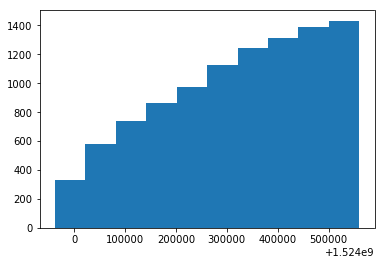

In [7]:
number_of_tx = 10000

#Задаём экспоненциальный рост торговли в сети со временем
start = '2018-04-17 12:00:00'
end = '2018-04-24 12:00:00'
intervals = interval_divide(start, end, 100)
weights = [math.sqrt(0.5*t) for t in range(len(intervals))]

uneven_tx_ts = sorted(generate_weighted_activity(intervals, weights))

#Проверяем гистограмму числа транзакций в сети по временным интервалам
plt.hist(uneven_tx_ts)
plt.show()

In [8]:
#Просто произвольные временные точки
startDate = datetime(2018, 4, 20, 12, 0, 0)
tx_timestamps = []

for x in list(random_date(startDate,number_of_tx)):
    tx_timestamps.append(int(x.timestamp()))
    #print (x.strftime("%Y-%m-%d %H:%M:%s"))

In [9]:
set_max_balances(G, token_supply)
set_start_balances(G, token_supply, token_distribution)
set_initial_history(G)

#Сумма частоток для отправлений равна 1
send = {'exchange':0.4, 'buyer':0.13, 'seller':0.16, 'hodler':0.05, 'speculator':0.26}
set_max_activity(G, 10000, send)


In [10]:
#Сумма равна 1, активность биржевого кошелька порядка 40% 
receive = {'exchange':0.4, 'buyer':0.16, 'seller':0.13, 'hodler':0.05, 'speculator':0.26}

node_receiver_weights = []
node_sender_weights = []

for node in G.nodes():
    if G.node[node]['account_type'] == 'exchange':
        node_sender_weights.append(send['exchange']/exchanges)
        node_receiver_weights.append(receive['exchange']/exchanges)
    if G.node[node]['account_type'] == 'buyer':
        node_sender_weights.append(send['buyer']/buyers)
        node_receiver_weights.append(receive['buyer']/buyers)
    if G.node[node]['account_type'] == 'seller':
        node_sender_weights.append(send['seller']/sellers)
        node_receiver_weights.append(receive['seller']/sellers)
    if G.node[node]['account_type'] == 'hodler':
        node_sender_weights.append(send['hodler']/hodlers)
        node_receiver_weights.append(receive['hodler']/hodlers)
    if G.node[node]['account_type'] == 'speculator':
        node_sender_weights.append(send['speculator']/speculators)
        node_receiver_weights.append(receive['speculator']/speculators)
        
#Нормируем веса так, чтобы их сумма равнялась [приблизительно] единице
norm_sender_weights = [float(i)/sum(node_sender_weights) for i in node_sender_weights]
norm_receiver_weights = [float(i)/sum(node_receiver_weights) for i in node_receiver_weights]


#Выбираем k отправителей и получателей с заданными весами, которые определяют их частоту появления в транзакции
send_list = list(random.choices(G.nodes(), norm_sender_weights, k=10000))
receive_list = list(random.choices(G.nodes(), norm_receiver_weights, k=10000))

#Формируем пары отправитель и получатель, удаляем пары, где они совпали
network_edges = [t for t in list(zip(send_list, receive_list)) if t[0] != t[1]]


In [11]:
#Моделируем суммы переводов пользователей TBD


In [12]:
#Запускаем торговлю между пользователями

for t in tqdm(uneven_tx_ts):
    edge = network_edges[uneven_tx_ts.index(t)]
    if edge[0] < edge[1]:
        amount = random.uniform(100, 0.3*G.node[edge[0]]['balance'])
    else:
        amount = random.uniform(100, 0.3*G.node[edge[1]]['balance'])
    tx = transaction(G, edge, amount, t)
    with open('transaction_history2.csv', 'a', newline='') as csvfile:
        writer = csv.writer(csvfile, delimiter=' ', quotechar='|')
        writer.writerow(tx)

  2%|▏         | 241/10000 [00:49<33:22,  4.87it/s]

KeyboardInterrupt: 

In [ ]:
c = 0
for edge in G.edges():
    if G.edge[edge[0]][edge[1]]['tx_history'] != [] and len(G.edge[edge[0]][edge[1]]['tx_history']) > 1:
        print(len(G.edge[edge[0]][edge[1]]['tx_history']))
        print(G.edge[edge[0]][edge[1]]['tx_history'])
        c += 1
print(c)